In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.layers import BatchNormalization



import requests
from bs4 import BeautifulSoup
import os
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
from tqdm import tqdm
import time


from sklearn.metrics import confusion_matrix
import seaborn as sns

Leemos los datos del archivo .fits

In [3]:
#archivos=['DataDESI_36.fits', 'DataDESI_72.fits', 'DataDESI_108.fits', 'DataDESI_144.fits', 'DataDESI_180.fits', 'DataDESI_216.fits'
 #, 'DataDESI_252.fits', 'DataDESI_288.fits', 'DataDESI_324.fits', 'DataDESI_360.fits', 'DataDESI_379.fits']
#archivos=['DataDESI_36.fits', 'DataDESI_72.fits']
archivos=['DataDESI_36.fits', 'DataDESI_72.fits', 'DataDESI_108.fits', 'DataDESI_144.fits', 'DataDESI_180.fits',
          'DataDESI_252.fits', 'DataDESI_324.fits', 'DataDESI_360.fits', 'DataDESI_379.fits']

#Generamos las listas con los datos:
Spectra_set= None #Este tensor contiene los elementos de flujo completo R+Z+B
y=np.array([]) #Esta lsita contiene las etiquetas para el ejercicio de clasificacion
z=np.array([]) #Esta matriz contiene los corrimientos z para el ejercicio de regresion

for h in range(len(archivos)):
    espc = fits.open(archivos[h]) #open file
    len_espc= len(espc[2].data)
    
    #leemos la informacion
    Bflux=espc[2].data
    Zflux=espc[4].data
    Rflux=espc[3].data
    
    spectra=np.hstack((Bflux, Zflux, Rflux)) #Contiene la cadena completa de flujo B+Z+R para cada espectro
    spectra=spectra.reshape(spectra.shape[0], spectra.shape[1], 1)
    
    if Spectra_set is None:
        Spectra_set = spectra
    else:
        Spectra_set = np.concatenate((Spectra_set, spectra), axis=0)
    
    y=np.append(y, Table.read(espc, hdu=1)['SPECTYPE'].data)
    
    z=np.append(z, Table.read(espc, hdu=1)['Z'].data)
    z=z.reshape(-1,1)

#Tenemos el tensor Spectra_set que contiene todos los flujos de los .fits seleccionados
#y es una lista con las etiquetas de dichos espectros
#z una matriz con los valores de corrimiento de cada espectro.


In [4]:
len(Spectra_set)

560373

Ejercicio de regresión. Aqui predecimos el valor del corrimiento al rojo 'z' de cada espectro

Epoch 1/50
9771/9771 [==============================] - 1415s 144ms/step - loss: 0.2671 - mse: 0.2671 - val_loss: 0.2249 - val_mse: 0.2249
Epoch 2/50
9771/9771 [==============================] - 1399s 143ms/step - loss: 0.1794 - mse: 0.1794 - val_loss: 0.1320 - val_mse: 0.1320
Epoch 3/50
9771/9771 [==============================] - 1402s 144ms/step - loss: 0.1509 - mse: 0.1509 - val_loss: 0.1152 - val_mse: 0.1152
Epoch 4/50
9771/9771 [==============================] - 1396s 143ms/step - loss: 0.1448 - mse: 0.1448 - val_loss: 0.1066 - val_mse: 0.1066
Epoch 5/50
9771/9771 [==============================] - 1403s 144ms/step - loss: 0.1409 - mse: 0.1409 - val_loss: 0.1013 - val_mse: 0.1013
Epoch 6/50
9771/9771 [==============================] - 1403s 144ms/step - loss: 0.1395 - mse: 0.1395 - val_loss: 0.1034 - val_mse: 0.1034
Epoch 7/50
9771/9771 [==============================] - 1398s 143ms/step - loss: 0.1366 - mse: 0.1366 - val_loss: 0.0974 - val_mse: 0.0974
Epoch 8/50
9771/9771 [=====

c:\users\daniel\appdata\local\programs\python\python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Mean Squared Error (MSE) or loss: 0.10312670469284058
Accuracy: 10.31%


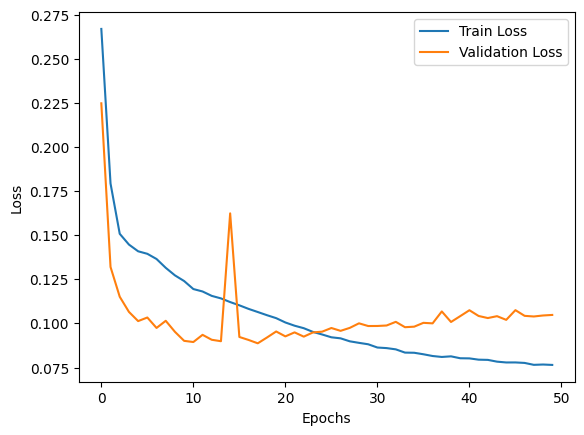

4420/4420 [==============================] - 143s 32ms/step


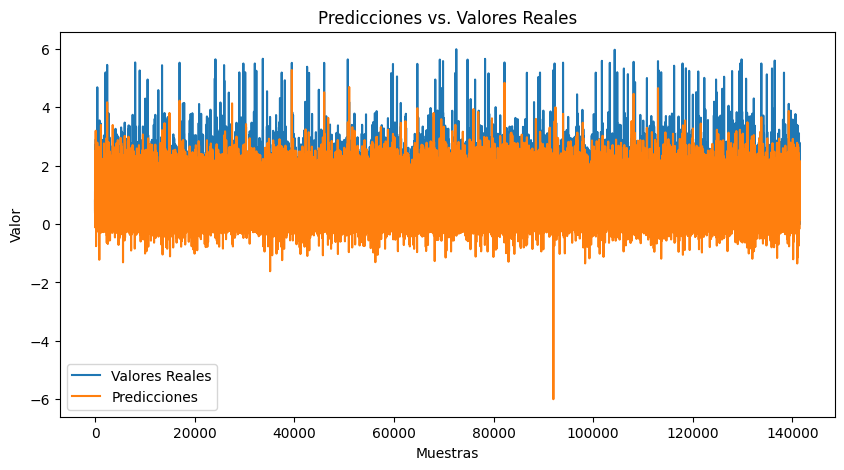

In [5]:
output_shape=1
X=Spectra_set
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, z, test_size=0.252371, random_state=42)


#Crea el modelo de CNN
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=15, activation='relu', strides=2, input_shape=(len(X[0]),1)))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=128, kernel_size=15, activation='relu', strides=2))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=256, kernel_size=15, activation='relu', strides=2))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=256, kernel_size=15, activation='relu', strides=2))
model.add(MaxPooling1D(pool_size=3))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))## considerar tanh
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation='linear'))  # Capa de salida lineal para regresión, output_shape debe ser =1

# Compila el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse']) ## considerar el mae y huber.

# Entrena el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.25371)

# Guardar el modelo y sus pesos en un solo archivo HDF5
model.save("mi_modelo_regresion_1.h5")

# Evalúa el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Mean Squared Error (MSE) or loss:", loss)
print(f'Accuracy: {accuracy * 100:.2f}%')

#Visualización del Rendimiento
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Visualizar las predicciones y los valores reales
plt.figure(figsize=(10, 5))
plt.scatter(z, predictions)
x_line = np.linspace(min(z), max(z), 100)  # Crear puntos para la línea
y_line = x_line  # Pendiente 1
plt.plot(x_line, y_line, color='red', linestyle='--', label="Pendiente 1")
plt.title("Predicciones en la Nueva Muestra de Datos")
plt.xlabel("Z_real")
plt.ylabel("Z_Pred")
plt.show()


# Visualizar las predicciones y los valores reales
#plt.figure(figsize=(10, 5))
#plt.plot(y_test, label="Valores Reales")
#plt.plot(predictions, label="Predicciones")
#plt.legend()
#plt.title("Predicciones vs. Valores Reales")
#plt.xlabel("Muestras")
#plt.ylabel("Valor")
#plt.show()

Ejercicio de clasifiación. Aqui predecimos la clase o tipo espectral de cada espectro de entrada

Epoch 1/100
10474/10474 [==============================] - 1479s 141ms/step - loss: 0.2625 - accuracy: 0.9171 - val_loss: 0.0946 - val_accuracy: 0.9782
Epoch 2/100
10474/10474 [==============================] - 1453s 139ms/step - loss: 0.1572 - accuracy: 0.9466 - val_loss: 0.0834 - val_accuracy: 0.9791
Epoch 3/100
10474/10474 [==============================] - 1461s 139ms/step - loss: 0.1392 - accuracy: 0.9544 - val_loss: 0.0627 - val_accuracy: 0.9817
Epoch 4/100
10474/10474 [==============================] - 1456s 139ms/step - loss: 0.1063 - accuracy: 0.9683 - val_loss: 0.0575 - val_accuracy: 0.9840
Epoch 5/100
10474/10474 [==============================] - 1448s 138ms/step - loss: 0.0918 - accuracy: 0.9739 - val_loss: 0.0584 - val_accuracy: 0.9828
Epoch 6/100
10474/10474 [==============================] - 1466s 140ms/step - loss: 0.0846 - accuracy: 0.9762 - val_loss: 0.0538 - val_accuracy: 0.9843
Epoch 7/100
10474/10474 [==============================] - 1454s 139ms/step - loss: 0.07

c:\users\daniel\appdata\local\programs\python\python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


loss: 0.1323925256729126
Accuracy: 98.42%


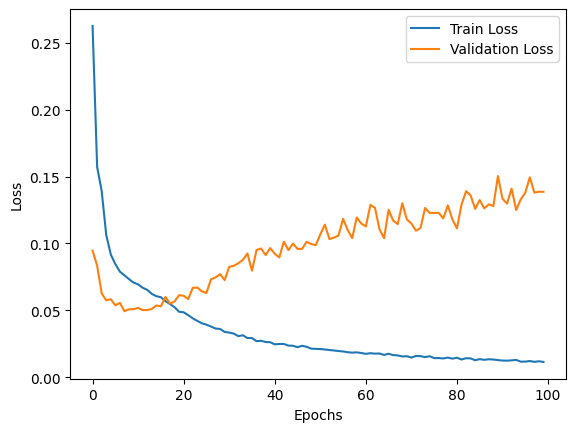

3148/4420 [====================>.........] - ETA: 40s

In [ ]:
num_classes = 3  # Número de clases
X=Spectra_set

#Aigna un numero entero a cada clase
y = np.array(y)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.252371, random_state=42)

# Convierte las etiquetas a codificación one-hot
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)      #Galazxy=[0,0,1]


# Crea el modelo de CNN
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=15, activation='relu', strides=2, input_shape=(len(X[0]),1)))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=128, kernel_size=15, activation='relu', strides=2))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=256, kernel_size=15, activation='relu', strides=2))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=256, kernel_size=15, activation='relu', strides=2))
model.add(MaxPooling1D(pool_size=3))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compila el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrena el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Guardar el modelo y sus pesos en un solo archivo HDF5
model.save("mi_modelo_clasifiacion_1.h5")

# Evalúa el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("loss:", loss)
print(f'Accuracy: {accuracy * 100:.2f}%')


#Visualización del Rendimiento
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Convierte las predicciones one-hot a etiquetas
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)


In [ ]:
# Obtener las etiquetas reales y predichas
true_labels = np.argmax(y_test, axis=1)
predicted_labels = np.argmax(predictions, axis=1)

# Crear la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión con seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Cargar los modelos de entrenamiento guardados